In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Reading and preprocessing data

First we need to convert dicom files to objects that we can use; CSV files, jpg or png images e.g. To do this, we can use pydicom library for reading dicom files and then converting them. For more information you can visit these links:

[https://asvcode.github.io/MedicalImaging/medical_imaging/dicom/fastai/2020/04/28/Medical-Imaging-Using-Fastai.html](http://)

[https://pydicom.github.io/pydicom/stable/tutorials/dataset_basics.html](http://)

In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom, kornia, cv2

train_dcm_path = get_dicom_files("../input/unifesp-x-ray-body-part-classifier/train")
test_dcm_path = get_dicom_files("../input/unifesp-x-ray-body-part-classifier/test")

print("train len:", len(train_dcm_path), "\ntest len:", len(test_dcm_path))

train len: 1738 
test len: 743


Now we can convert some parts of dicom file to pandas dataset. Thanks to Mr.Bombonato, he convert these dicom files to csv files you can find here:

[https://www.kaggle.com/datasets/ibombonato/unifesp-xray-body-part-dicom-metadata-csv](http://)

In [3]:
train_dcm2csv_df = pd.read_csv('../input/unifesp-xray-body-part-dicom-metadata-csv/dicom_metadata_train.csv')
train_dcm2csv_df

,MultiImageType,ImageType,ImageType1,InstanceCreationDate,InstanceCreationTime,SOPClassUID,SOPInstanceUID,StudyDate,SeriesDate,ContentDate,...,WindowCenter,WindowWidth,ImageType2,KVP,DistanceSourceToDetector,DistanceSourceToPatient,ExposureTime,XRayTubeCurrent,AcquisitionNumber,ImageType3
0,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.71157989004260882669063657298878631277,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.32467620439025796224161045738740609166,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.74856220852423198555486702707715689735,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.90865692473901867788171201500090752135,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.44687741644515558201307438644049640452,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.84195286770915865285283493888654502396,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1734,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.11211536623788107002735898165090841538,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1735,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.97523800054763336883452748817549462853,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1736,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.13690494879381638155074323667482680582,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Furthermore, there's another csv file in the main dataset that includes "SOP IDs" and "targets".

In [4]:
train_df = pd.read_csv('../input/unifesp-x-ray-body-part-classifier/train.csv')
train_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,2


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738 entries, 0 to 1737
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1738 non-null   object
 1   Target          1738 non-null   object
dtypes: object(2)
memory usage: 27.3+ KB


In [6]:
train_df['Target'].unique()

array(['0 ', '15 ', '12 ', '14 ', '3 ', '13 20 ', '5 ', '17 ', '2 ', '6 ',
       '9 21 ', '9 ', '16 ', '7 ', '11 ', '1 ', '20 ', '21 ', '13 ',
       '0 3 ', '8 ', '1 11 12 ', '0 15 ', '19 ', '10 ', '4 ', '11 12 ',
       '1 6 ', '10 19 ', '5 8 ', '3 15 ', '7 9 ', '15 19 ', '2 13 20 ',
       '18 ', '3 6 ', '2 20 ', '10 11 19 ', '1 12 ', '3 7 ', '8 16 '],
      dtype=object)

The labels are represented as integers that map to the following:


* Abdomen = 0
* Ankle = 1
* Cervical Spine = 2
* Chest = 3
* Clavicles = 4
* Elbow = 5
* Feet = 6
* Finger = 7
* Forearm = 8
* Hand = 9
* Hip = 10
* Knee = 11
* Lower Leg = 12
* Lumbar Spine = 13
* Others = 14
* Pelvis = 15
* Shoulder = 16
* Sinus = 17
* Skull = 18
* Thigh = 19
* Thoracic Spine = 20
* Wrist = 21

As you see, some of dicom files have more that one class (target)! So, we have a multilabel classification problem. This is my strategy:

First we add all labels to the "train_df" as new columns by their orders and set all to zero. Then by considering the numbers in the target column of each record, we replace 1 in the columns related that number. 

For example, suppose that target have two numbers: "1 , 6". These numbers represent "ankle, feet". We replace 1 in "ankle" and "feet" columns of that record.

In [7]:
train_df['Abdomen'] = 0
train_df['Ankle'] = 0
train_df['Cervical Spine'] = 0
train_df['Chest'] = 0
train_df['Clavicles'] = 0
train_df['Elbow'] = 0
train_df['Feet'] = 0
train_df['Finger'] = 0
train_df['Forearm'] = 0
train_df['Hand'] = 0
train_df['Hip'] = 0
train_df['Knee'] = 0
train_df['Lower Leg'] = 0
train_df['Lumbar Spine'] = 0
train_df['Others'] = 0
train_df['Pelvis'] = 0
train_df['Shoulder'] = 0
train_df['Sinus'] = 0
train_df['Skull'] = 0
train_df['Thigh'] = 0
train_df['Thoracic Spine'] = 0
train_df['Wrist'] = 0
train_df

,SOPInstanceUID,Target,Abdomen,Ankle,Cervical Spine,Chest,Clavicles,Elbow,Feet,Finger,...,Lower Leg,Lumbar Spine,Others,Pelvis,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
labels = ['Abdomen', 'Ankle', 'Cervical Spine', 'Chest', 'Clavicles', 'Elbow', 'Feet', 'Finger', 'Forearm', 'Hand', 'Hip', 'Knee', 'Lower Leg', 'Lumbar Spine', 'Others', 'Pelvis', 'Shoulder', 'Sinus', 'Skull', 'Thigh', 'Thoracic Spine', 'Wrist']

for i in range(len(train_df)):
    lbl_list = train_df.Target[i].split()
    
    for j in lbl_list:
        train_df.loc[i, labels[int(j)]] = 1
        

train_df[:10]

,SOPInstanceUID,Target,Abdomen,Ankle,Cervical Spine,Chest,Clavicles,Elbow,Feet,Finger,...,Lower Leg,Lumbar Spine,Others,Pelvis,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.2.826.0.1.3680043.8.498.10053755320637729867508668285241208441,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.2.826.0.1.3680043.8.498.10062189329714053601496804394945741428,14,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,1.2.826.0.1.3680043.8.498.10065930002825553435161793347987832017,13 20,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
8,1.2.826.0.1.3680043.8.498.10072001800484199846734151421006166369,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.8.498.10077219503857952412254959562456136784,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we merge two dataframs based on "SOPInstanceUID" columns. So we have an integrated dataframe which help us to create "X" and "y" of model much easier.

In [9]:
train_merged_df = pd.merge(train_dcm2csv_df, train_df, on='SOPInstanceUID')
train_merged_df

,MultiImageType,ImageType,ImageType1,InstanceCreationDate,InstanceCreationTime,SOPClassUID,SOPInstanceUID,StudyDate,SeriesDate,ContentDate,...,Lower Leg,Lumbar Spine,Others,Pelvis,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist
0,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.71157989004260882669063657298878631277,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.32467620439025796224161045738740609166,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.74856220852423198555486702707715689735,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.90865692473901867788171201500090752135,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.44687741644515558201307438644049640452,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.84195286770915865285283493888654502396,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1734,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.11211536623788107002735898165090841538,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1735,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.97523800054763336883452748817549462853,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
1736,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.2.826.0.1.3680043.8.498.13690494879381638155074323667482680582,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1


An example of converting dicom file to jpg image:

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


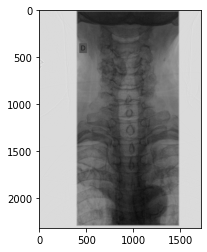

In [10]:
tmp = train_dcm_path[np.random.randint(0, 1737)].dcmread()
dcm_img = tmp.pixel_array.astype(float)
img = np.uint8((np.maximum(dcm_img,0)/dcm_img.max())*255)
plt.imshow(img, cmap='gray')

This step is the most time consuming part of the code; 

First we should reading dicom files and convert them to jpg images but there is a big problem; The size of dicom images are too big; for example 3000 * 4000 pixels! There isn't enough memory so we should resize all of them to 128 * 128 pixels but unfortunately it will have consequences like information loss. If you have enough memory, you can resize them to 512 * 512 pixels for example. Anyway, the images create X array for training.

The "y" of model, is an array of 1738 * 22. In another words, the label of each image (each SOPInstanceUID) is a vector contains 22 binary numbers that represent 22 labels (body parts). 

In [11]:
import cv2
from matplotlib import pyplot as plt

X = []
y = []
for i in range(len(train_dcm_path)):
    tmp = train_dcm_path[i].dcmread()
    
    dcm_img = tmp.pixel_array.astype(float)
    rescaled_img = np.uint8((np.maximum(dcm_img,0)/dcm_img.max())*255)
    image = cv2.resize(rescaled_img, dsize=(128,128), interpolation=cv2.INTER_AREA)/255 #resizing and normalizing
    X.append(np.expand_dims(image,axis=-1))
    
    uid = str(tmp['SOPInstanceUID'].value)
    y.append(np.ndarray.flatten(np.array(train_merged_df.loc[train_merged_df['SOPInstanceUID'] == uid][train_merged_df.columns[64:]])))
    
X = np.array(X)
y = np.array(y)

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "
/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:239: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({bits_stored}-bit) "


# Training and testing custom CNN model

First we should split X and y data to train and test data.

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

To avoid of overfitting, we can use "EarlyStopping" callback; So we need to split train data to "train" and "validation" parts.

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]


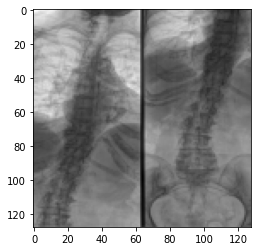

In [56]:
### A sample of X_train and related y_train ###

plt.imshow(X_train[7], cmap='gray')
print(y_train[7])

Now, we can build our CNN model.

In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

cnn_model = Sequential()
cnn_model.add(InputLayer(input_shape=(128,128,1)))
              
cnn_model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
#cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
#cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(4096, activation="relu"))
cnn_model.add(Dense(2048, activation="relu"))
cnn_model.add(Dense(22, activation="sigmoid"))

cnn_model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 256)      

In [63]:
history = cnn_model.fit(x = X_train,
                        y = y_train,
                        batch_size = 8,
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                        validation_data = (X_val, y_val),
                        verbose = 1,
                        epochs = 50)

Epoch 1/50
167/167 [==============================] - 5s 25ms/step - loss: 0.2422 - accuracy: 0.4477 - val_loss: 0.1601 - val_accuracy: 0.4324
Epoch 2/50
167/167 [==============================] - 4s 24ms/step - loss: 0.1353 - accuracy: 0.4755 - val_loss: 0.1390 - val_accuracy: 0.4459
Epoch 3/50
167/167 [==============================] - 4s 24ms/step - loss: 0.1179 - accuracy: 0.5132 - val_loss: 0.1167 - val_accuracy: 0.5068
Epoch 4/50
167/167 [==============================] - 4s 25ms/step - loss: 0.1029 - accuracy: 0.5696 - val_loss: 0.1102 - val_accuracy: 0.5541
Epoch 5/50
167/167 [==============================] - 4s 24ms/step - loss: 0.0947 - accuracy: 0.6110 - val_loss: 0.1214 - val_accuracy: 0.5270
Epoch 6/50
167/167 [==============================] - 4s 24ms/step - loss: 0.0809 - accuracy: 0.6682 - val_loss: 0.0914 - val_accuracy: 0.6284
Epoch 7/50
167/167 [==============================] - 4s 24ms/step - loss: 0.0636 - accuracy: 0.7404 - val_loss: 0.0900 - val_accuracy: 0.6284

Plotting results of trained model involvs accuracy, validation accuracy, loss and validation loss

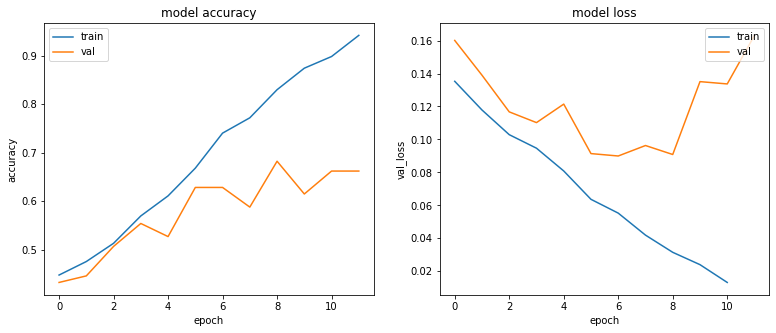

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'][1:])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()

The accuracy of the model on test data:

In [65]:
cnn_model.evaluate(x = X_test,
                   y = y_test,
                   verbose=1)

9/9 [==============================] - 0s 13ms/step - loss: 0.1494 - accuracy: 0.7203


[0.14937275648117065, 0.7203065156936646]

# Prediction

First select a dicom file from test data and convert it to jpg image same as training phase. Then pass it to "predict" function and get output.

After some tests, I set threshold = 0.1 which means if score is greater than 0.1, the related label is in that test image. 

['Chest']


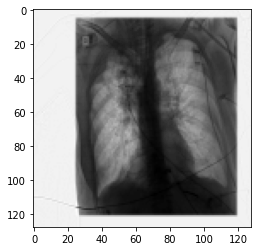

In [66]:
test_candid = test_dcm_path[np.random.randint(0, 742)].dcmread()
dcm_img = test_candid.pixel_array.astype(float)
converted_img = np.uint8((np.maximum(dcm_img,0)/dcm_img.max())*255)
resized_img = cv2.resize(converted_img, dsize=(128,128), interpolation=cv2.INTER_AREA)/255
test_img = np.expand_dims(resized_img, axis=-1)
plt.imshow(test_img, cmap='gray')

image = np.expand_dims(test_img, axis=0)
prdct_arr = cnn_model.predict(image)

body_parts = []
prdct_arr = prdct_arr.flatten()
for i in range(len(prdct_arr)):
    if (prdct_arr[i] > 0.1):
        body_parts.append(labels[i])

print(body_parts)